In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [4]:
df.shape

(1000209, 20)

In [5]:
df.head()

,userId,itemId,rating,timestamp,gender,age,occupation,zip,title,genre,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid,gender_idx,age_idx,title_idx,genre_idx,zip_idx
648724,3908,2347,4,965941231,M,25,0,10021,"Pope of Greenwich Village, The (1984)",Action,train,1,1,1,0,1,1,1,1,1
203881,1254,1541,2,974823280,F,18,1,02144,Addicted to Love (1997),Comedy|Romance,train,2,2,1,0,2,2,2,2,2
243394,1467,2617,3,977173059,M,25,5,97007,"Mummy, The (1999)",Action|Adventure|Horror|Thriller,train,3,3,1,0,1,1,3,3,3
788507,4717,3754,3,963502544,M,45,17,48310,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,train,4,4,1,0,1,3,4,4,4
301066,1789,2997,5,974700402,M,1,10,19116,Being John Malkovich (1999),Comedy,train,5,5,1,0,1,4,5,5,5


In [6]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [7]:
df_train.head()

,userId,itemId,rating,timestamp,gender,age,occupation,zip,title,genre,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid,gender_idx,age_idx,title_idx,genre_idx,zip_idx
648724,3908,2347,4,965941231,M,25,0,10021,"Pope of Greenwich Village, The (1984)",Action,train,1,1,1,0,1,1,1,1,1
203881,1254,1541,2,974823280,F,18,1,02144,Addicted to Love (1997),Comedy|Romance,train,2,2,1,0,2,2,2,2,2
243394,1467,2617,3,977173059,M,25,5,97007,"Mummy, The (1999)",Action|Adventure|Horror|Thriller,train,3,3,1,0,1,1,3,3,3
788507,4717,3754,3,963502544,M,45,17,48310,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,train,4,4,1,0,1,3,4,4,4
301066,1789,2997,5,974700402,M,1,10,19116,Being John Malkovich (1999),Comedy,train,5,5,1,0,1,4,5,5,5


### Dataset and DataLoader

In [8]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [9]:
dstrain=cfdata(df_train[['user_idx','item_idx']],df_train['rating'])
dsvalid=cfdata(df_valid[['user_idx','item_idx']],df_valid['rating'])

In [10]:
df_train.shape

(900188, 20)

In [33]:
bs=128

In [34]:
dltrain=DataLoader(dstrain,bs,True)

In [35]:
dlvalid=DataLoader(dsvalid,bs,True)

In [14]:
len(user_to_idx),len(movie_to_idx)

(6040, 3706)

## Model Architecture

In [16]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=50
n_emb_movie=50
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.05
hidden=[25,10]
dropouts=[0.2,0.2]

In [17]:
n_users

6040

In [18]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [19]:
n_users

6040

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e)

In [21]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [24]:
cfobj.forward(Xb,Yb)

(tensor([[3.6606],
         [1.5203],
         [3.4671],
         [4.9966],
         [3.6201],
         [3.8540],
         [1.4089],
         [1.2750],
         [1.8318],
         [1.1933],
         [4.7646],
         [1.5428],
         [3.4752],
         [3.4068],
         [1.4951],
         [4.5982],
         [1.1155],
         [4.7248],
         [2.5644],
         [3.1270],
         [3.5594],
         [4.6349],
         [3.8652],
         [1.7298],
         [1.4475],
         [2.3576],
         [1.1651],
         [4.2522],
         [2.5706],
         [2.8125],
         [1.5276],
         [3.0564],
         [4.2375],
         [4.8265],
         [2.1420],
         [2.4143],
         [4.5921],
         [4.0387],
         [1.0873],
         [4.2413],
         [3.5736],
         [2.9105],
         [3.5948],
         [1.7189],
         [4.3363],
         [4.6144],
         [2.3465],
         [2.8166],
         [4.8454],
         [1.3536],
         [4.3273],
         [1.1244],
         [2.

## Learner

In [25]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        acc=np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{acc} Valid RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [26]:
if 1==0:
    del cfobj
    torch.cuda.empty_cache()

In [27]:
device='cuda:1'

In [28]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e)

In [29]:
cfobj=cfobj.to(device)

In [30]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [36]:
len(dltrain), dltrain.batch_size

(7033, 128)

In [38]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,10000,0.25,cycle_mult=0)

In [39]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

(None, 0.907893180847168)

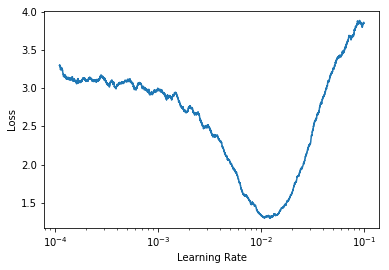

In [40]:
learner.plot_lrs(100), min(learner.losses)

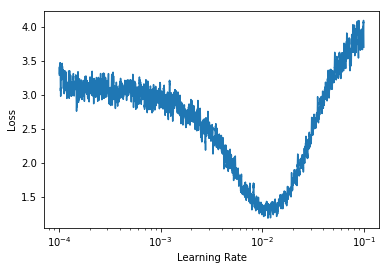

In [41]:
learner.plot_lrs(10)

In [55]:
del cfobj
torch.cuda.empty_cache()

In [56]:
device="cuda:0"

In [57]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [58]:
wd=1e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0)

In [59]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.005 Weight Decay 1e-05 Train Loss:1.2036557955404916                 Valid Loss:0.8382982896721881 Train RMSE:1.074118573088231 Valid RMSE:0.9134461647387792
Epoch:1 Learning rate 0.005 Weight Decay 1e-05 Train Loss:0.7913393309483161                 Valid Loss:0.8043077422682282 Train RMSE:0.8873655859850806 Valid RMSE:0.8948467277970791


In [60]:
for param_group in optimizer.param_groups:
    param_group['lr']=5e-4
learner.lr=5e-4

In [61]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.0005 Weight Decay 1e-05 Train Loss:0.6141152312741007                 Valid Loss:0.7534994262716045 Train RMSE:0.7816698318710154 Valid RMSE:0.8660318702653416
Epoch:1 Learning rate 0.0005 Weight Decay 1e-05 Train Loss:0.561223255834555                 Valid Loss:0.7410507773804238 Train RMSE:0.7473021136905531 Valid RMSE:0.8586897426772436


In [67]:
for param_group in optimizer.param_groups:
    param_group['lr']=1e-4
learner.lr=1e-4
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.0001 Weight Decay 1e-05 Train Loss:0.5183829474496617                 Valid Loss:0.7400920890328829 Train RMSE:0.7182720033529506 Valid RMSE:0.8581924324832734
Epoch:1 Learning rate 0.0001 Weight Decay 1e-05 Train Loss:0.51370837763704                 Valid Loss:0.7398116785242125 Train RMSE:0.7149849826713514 Valid RMSE:0.8581719245868127


In [68]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [69]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [70]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((6041, 50), (3707, 50), (6041, 1), (3707, 1))

In [71]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))

In [72]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
